# Récupération des données

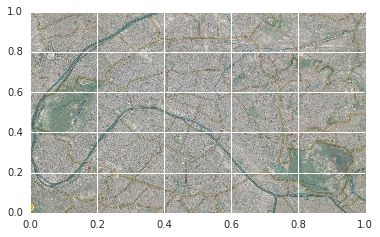

In [35]:
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

fname="velib-enpc.npz"
with  np.load(fname) as obj:
    # Dictionnaire des informations des stations idvelib->(nom,adresse,x,y,nbre attaches,long,lat)
    stations = dict(obj['stations'].tolist())
    # Correspondance idvelib->ligne matrice
    stations_idx = dict(obj['stations_idx'].tolist())
    # Correspondance ligne matrice->idvelib
    idx_stations = dict(obj['idx_stations'].tolist())
    # Matrice du nombre de velos dispo par station par minute
    histo = obj['histo']

# Permet d'afficher la carte de Paris
def show_map():
    plt.imshow(parismap,extent=[0,1,0,1],aspect=0.6)
    
parismap = mpimg.imread("paris.jpg")
show_map()

# Estimation de densité

## Histogramme

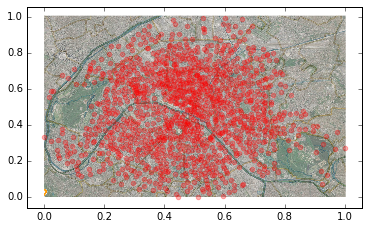

In [4]:
geo_data = np.array([ [x[2],x[3],x[4]] for x in stations.values()])
show_map()
plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.3,color="red")

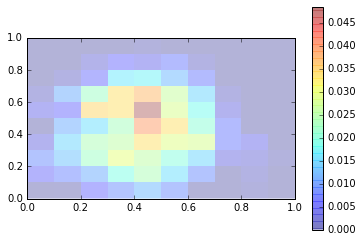

In [5]:
def histog(data, STEPS=10):
    ### Constitution du résultat
    weights = np.ones(np.shape(geo_data)[0]) # Ici on utilise des pas constants.
    weights = weights/np.sum(weights)# Normalized weights
    resultat = np.zeros((STEPS, STEPS))

    i_normed = (data[:,0]-np.min(data[:, 0]))/(np.max(data[:, 0])-np.min(data[:, 0]))
    j_normed = (data[:, 1]-np.min(data[:, 1]))/(np.max(data[:, 1])-np.min(data[:, 1]))
    ind_i = np.floor(i_normed*(STEPS-1))
    ind_j = np.floor(j_normed*(STEPS-1))
    ind_i, ind_j = ind_i.astype(int), ind_j.astype(int)
    for point in range(np.shape(i_normed)[0]):
        resultat[ind_i[point], ind_j[point]] += 1

    # Normalisation
    resultat = resultat/resultat.sum()
    return resultat
    

result = histog(geo_data)
plt.imshow(result.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6)
plt.colorbar()
#plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.3,color="red")

On va maintenant essayer d'augmenter la taille de la grille pour avoir une estimation plus précise des densités

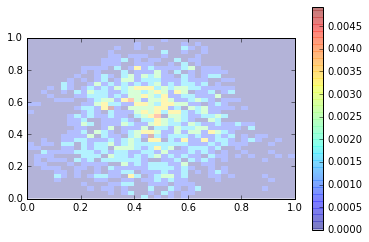

In [6]:
result_40 = histog(geo_data, 40)
plt.imshow(result_40.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6)
plt.colorbar()

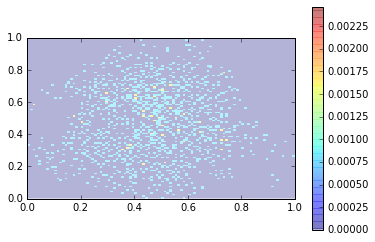

In [7]:
result_100 = histog(geo_data, 100)
plt.imshow(result_100.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6)
plt.colorbar()

On remarque qu'en fonction de la taille de la grille, les densités estimées fluctuent beaucoup, et que très rapidement, on peut se retrouver avec des patchs trop petits.

Dans notre modélisation, on a seulement utilisé un paramètre, le nombre d'hypercube par dimension.
L'avantage, c'est que même si cette méthode est imprécise et naïve, le nombre de paramètres reste constant même quand on passe à des dimensions supérieures.

## Fenêtres de Parzen

In [8]:
def uni(x, data, sigma): 
    """Returns 1 if all coordinates are between -0.5 and 0.5
    and 0 otherwise"""
    data_kernel = (x-data)/sigma
    result = np.zeros(np.shape(data)[0])
    indices = np.where(np.absolute(np.max(data_kernel, axis=1)) <= 0.5)
    result[indices] = 1
    return result

def gaussian(x, data, sigma):
    n, d = np.shape(data)
    data_kernel = (x-data)/sigma
    norm = np.linalg.norm(data_kernel, axis=1)
    res = np.exp((-0.5*np.square(norm))*((2*np.pi)**(d/2)))
    return res

In [9]:
def parzen(x, data, weight, sigma, kernel):
    # Normalizing weight
    wei = weight/np.sum(weight)
    n, d = np.shape(data)
    kernels = kernel(x, data, sigma)
    density = np.dot(wei.T, kernels)
    density = density/(sigma**d)
    return density

In [10]:
x = np.array([0.7, 0.5])
parzen(x, geo_data[:,:2], geo_data[:,2], 0.05, uni)

12.005224030540484

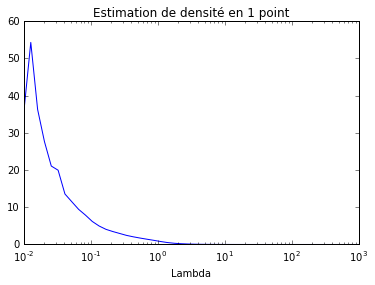

In [11]:
params = np.logspace(-2, 3, num=50)
density_x = [parzen(x, geo_data[:,:2], geo_data[:,2], sig, uni)
            for sig in params]
plt.plot(params, density_x)
plt.xscale('log')
plt.title('Estimation de densité en 1 point')
plt.xlabel("Lambda")

In [12]:
# def parzen_grid(data, weight, sigma, kernel, steps):
#     grid = np.mgrid[0:1:50j, 0:1:50j]
#     densities = np.zeros(np.shape(grid))
#     for i in np.shape(grid)[0]:
#         for j in np.shape(grid)[1]:
#             densities[i, j] = parzen(grid[i, j], data, weight, sigma, kernel)
            
            
def parzen_hist(data, sigma, kernel):
    xx,yy=np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
    grid = np.c_[xx.ravel(),yy.ravel()]
    pdf=np.array([parzen(g,data[:,:2],data[:,2],sigma,kernel) for g in grid]).reshape((STEPS,STEPS))
    plt.imshow(pdf,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin="lower")
    plt.colorbar()
    #plt.scatter(data[:,0],data[:,1],alpha=0.15,color="red")
    #return pdf
    #plt.scatter(train_data[:,0],train_data[:,1],alpha=0.15,color="red")

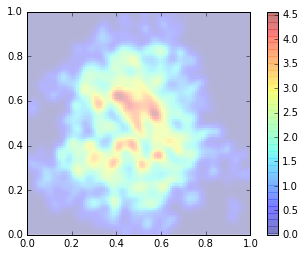

In [13]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
sigma = 0.05
STEPS=100
parzen_hist(geo_data, sigma, gaussian)


En complément, on remarque que quand on fait tendre $\sigma$ vers 0, on tend à surapprendre, et quand on tend vers l'infini à le plus apprendre, comme le suggèrent les 2 courbes suivantes:

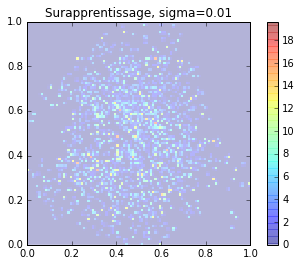

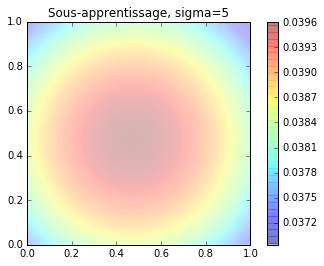

In [14]:
parzen_hist(geo_data, 0.01, gaussian)
plt.title('Surapprentissage, sigma=0.01')
plt.figure()
parzen_hist(geo_data, 5, gaussian)
plt.title('Sous-apprentissage, sigma=5')

PENSER A FAIRE ENSEMBLE DE TEST/VALIDATION POUR ESTIMATION D'ERREUR ET CONSIDERER
$L= \prod p(x_i, \theta) $

OU PLUTOT $-log(L)$

On peut difficilement appliquer l'erreur des moindres carrés comme estimateur car la densité réelle nous est inconnue.
En revanche, on pourra procéder par validation simple, en estimant la -log-vraisemblance  $-\sum_{\text{ensemble de test}} \log (p(x_i | \theta))$ sur l'ensemble de test.

In [15]:
def score(X_train, X_valid, weight, sigma, kernel):
    likelihood = 0
    for valid_point in X_valid:
        likelihood -= np.log(parzen(valid_point, X_train, weight, sigma, kernel))
    return likelihood

X_train, X_valid = train_test_split(geo_data, test_size=0.2)
weight = X_train[:,2]
X_train = X_train[:,:2]
X_valid = X_valid[:,:2]
score(X_train, X_valid, weight, 0.05, gaussian)

-80.409081500757722

COMPARAISON DES DIFFERENTS NOYAUX A FAIRE

# TODO TOUT METTRE SOUS FORMES DE CLASSES

# Estimateur de Nadaraya-Watson et K-plus proches voisins

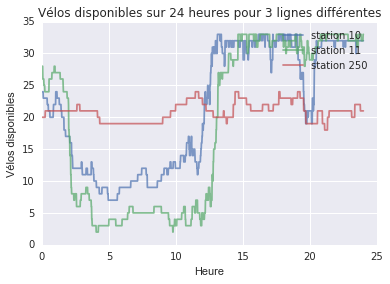

In [63]:
x = np.linspace(0,24, num=60*24)
plt.plot(x, histo[10,:60*24], label='station 10', alpha=0.7)
plt.plot(x, histo[11,:60*24], label='station 11', alpha=0.7)
plt.plot(x, histo[250,:60*24], label='station 250', alpha=0.7)
plt.title('Vélos disponibles sur 24 heures pour 3 lignes différentes')
plt.ylabel('Vélos disponibles')
plt.xlabel('Heure')
plt.legend()

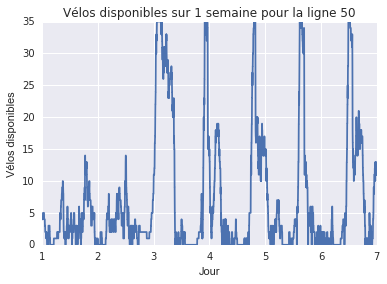

In [64]:
x_week = np.linspace(1,7, num=60*24*7)
plt.plot(x_week, histo[50,:60*24*7])
plt.title('Vélos disponibles sur 1 semaine pour la ligne 50')
plt.ylabel('Vélos disponibles')
plt.xlabel('Jour')

In [68]:
# Implémentation de l'estimateur de Nadaraya
class NWregressor:
    def __init__(self, kernel=gaussian):
        self.X_train = None
        self.y_train = None
        self.kernel = kernel
    def fit(self, X_train, y_train):
        """A bit misleading because nothing is 'fitted' here, but we choose
        to use that name by convention"""
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, x):
        kernels = self.kernel(self.X_train)
        return np.dot(y_train.T, kernels)/np.sum(kernels)
    

In [ ]:
# Variable à prédire: demande de vélos
